In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("data.csv", encoding="latin1", low_memory=False)
x = pd.to_numeric(df["no2"], errors="coerce").dropna().values

In [3]:
r = 102303327
a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)
print(a)
print(b)

0.0
0.8999999999999999


In [4]:
z = x + a * np.sin(b * x)
z = (z - np.mean(z)) / np.std(z)
z = z.reshape(-1, 1)

In [5]:
latent_dim = 1
epochs = 2200
batch_size = 64
lr = 0.0002

In [6]:
gen = Sequential()
gen.add(Dense(12, input_dim=latent_dim))
gen.add(LeakyReLU(0.2))
gen.add(Dense(12))
gen.add(LeakyReLU(0.2))
gen.add(Dense(1))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
disc = Sequential()
disc.add(Dense(12, input_dim=1))
disc.add(LeakyReLU(0.2))
disc.add(Dense(12))
disc.add(LeakyReLU(0.2))
disc.add(Dense(1, activation="sigmoid"))

disc.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr),
    metrics=["accuracy"]
)

In [8]:
disc.trainable = False
gan = Sequential()
gan.add(gen)
gan.add(disc)
gan.compile(loss="binary_crossentropy", optimizer=Adam(lr))

In [9]:
for i in range(epochs):

    idx = np.random.randint(0, z.shape[0], batch_size)
    real_samples = z[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = gen.predict(noise, verbose=0)

    disc.trainable = True
    disc.train_on_batch(real_samples, np.ones((batch_size, 1)))
    disc.train_on_batch(fake_samples, np.zeros((batch_size, 1)))

    disc.trainable = False
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gan.train_on_batch(noise, np.ones((batch_size, 1)))

In [10]:
noise = np.random.normal(0, 1, (10000, latent_dim))
z_fake = gen.predict(noise).flatten()
kde = gaussian_kde(z_fake)
z_axis = np.linspace(min(z_fake), max(z_fake), 300)
pdf = kde(z_axis)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


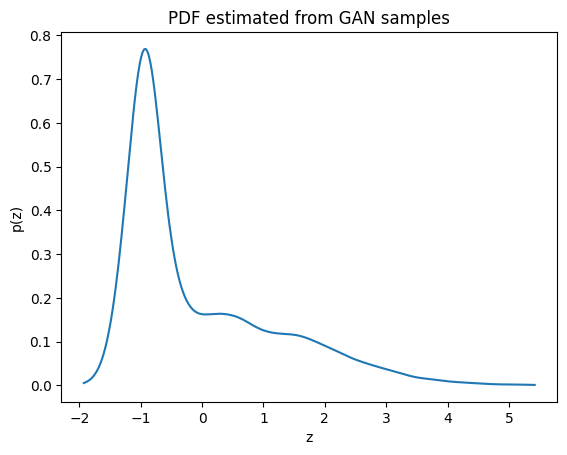

In [11]:
plt.plot(z_axis, pdf)
plt.xlabel("z")
plt.ylabel("p(z)")
plt.title("PDF estimated from GAN samples")
plt.show()